# Impulse Response Function (IRF) estimation: standard optimization in the time domain

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import minimize

import matplotlib.pyplot as plt

## load data

In [2]:
data_dir = "/Users/aponte/Current_Projects/das/work/ifr_debug/DASnsr_CTDtdt"

i=1
#files = glob(os.path.join(data_dir, f"S{i}*.nc"))

T_files = [
    "S1_ctd_temperature_dt.nc",
    "S2_ctd_temperature_dt.nc",
    "S3_ctd_temperature_dt.nc",
    "S4_ctd_temperature_dt.nc",
]

S_files = [
    "S1_das_nstrain_rate_d03424-03522m.nc",
    "S2_das_nstrain_rate_d04166-04264m.nc",
    "S3_das_nstrain_rate_d07309-07407m.nc",
    "S4_das_nstrain_rate_d09945-10043m.nc",
]


#f, s = T_files[0], S_files[0]
D = []
for f, s in zip(T_files, S_files):
    ds_t = xr.open_dataset(os.path.join(data_dir, f))
    ds_s = (
        xr.open_dataset(os.path.join(data_dir, s))
        .rename(**{'__xarray_dataarray_variable__': "strain_rate"})
    )
    ds = xr.merge([ds_t, ds_s])
    D.append(ds)

Large amount of noise in the das strain rate that is likely not related to temperature:

<Axes: xlabel='time', ylabel='strain_rate'>

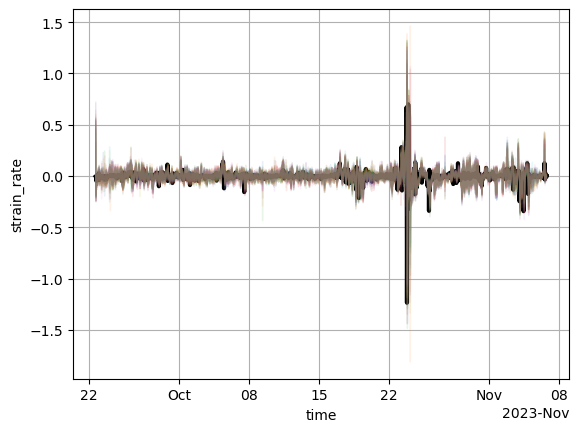

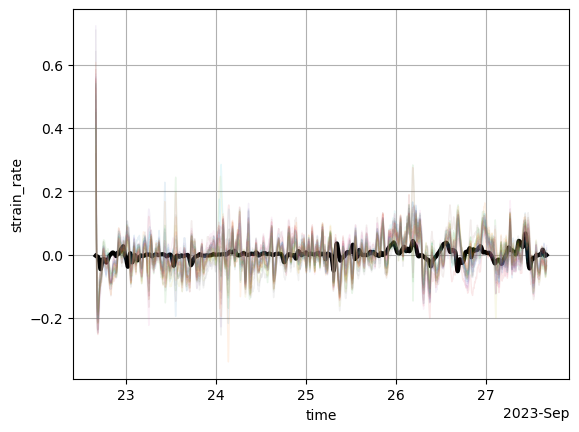

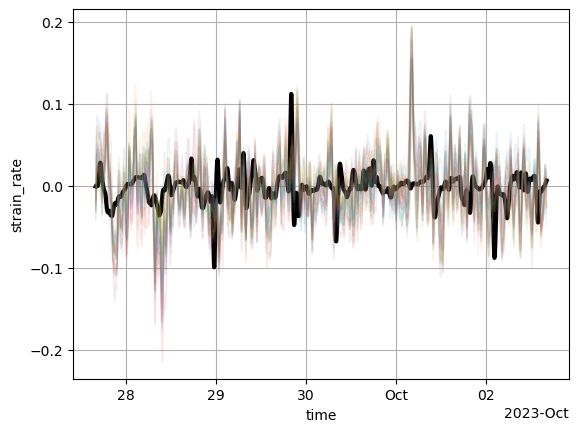

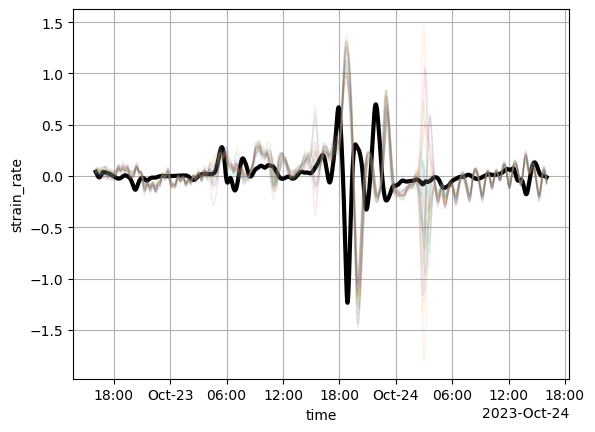

In [3]:
def plot(ds):
    fig, ax = plt.subplots(1,1)
    (ds["temperature_dt"]*3600).plot(x="time", label="temperature_dt", color="k", lw=3)
    ds["strain_rate"].plot(x="time", hue="distance", label="strain_rate", lw=1, alpha=.1, add_legend=False)
    #ax.legend()
    ax.grid()
    return ax

plot(D[2])
plot(D[2].isel(time=slice(0,24*60*5)))
#plot(ds.isel(time=slice(0,24*60)))
#plot(ds.isel(time=slice(0,2*60)));
plot(D[2].isel(time=slice(24*60*5,24*60*10)))
plot(D[2].isel(time=slice(24*60*30,24*60*32)))

Last figure above is a focus on the large event around the 23 of october

Inspect hourly averaged timeseries

<Axes: xlabel='time', ylabel='strain_rate'>

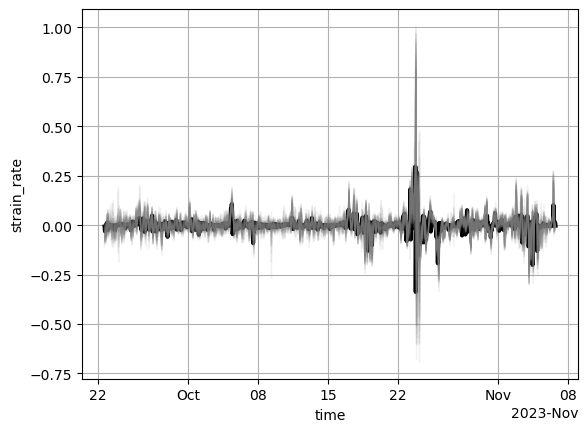

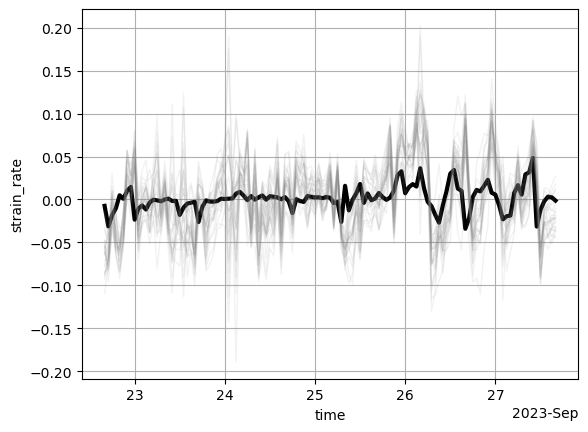

In [4]:
def plot(ds):
    
    _ds = ds.resample(time="60min").mean()
    
    fig, ax = plt.subplots(1,1)
    (_ds["temperature_dt"]*3600).plot(x="time", label="temperature_dt", color="k", lw=3)
    sr = _ds["strain_rate"]
    sr.plot(x="time", color="0.5",hue="distance", label="strain_rate", lw=1, alpha=.1, add_legend=False)
    #srm = sr.mean("distance")
    #srm.plot(color="C1")
    #(sr-srm).plot(x="time", color="0.5",hue="distance", label="strain_rate", lw=1, alpha=.1, add_legend=False)
    #ax.legend()
    ax.grid()
    return ax

plot(D[2])
plot(D[2].isel(time=slice(0,24*60*5)))
#plot(ds.isel(time=slice(0,24*60)))
#plot(ds.isel(time=slice(0,2*60)));
#plot(D[2].isel(time=slice(24*60*5,24*60*10)))
#plot(D[2].isel(time=slice(24*60*30,24*60*32)))

## inference of the impulse response function

Data is noisy and the recommandation is to use the Powell or Nelder-Mead algorithm:

https://scipy-lectures.org/advanced/mathematical_optimization/#choosing-a-method

In [10]:
def irf_inference(
    temperature, das, irf_length, 
    symmetrical=False,
    #lambda_l2=.1, lambda_smooth=.1,
    lambda_l2=0, lambda_smooth=0,
    demean=True,
    opt="powell",
    opt_kwargs={},
):
    """ perform an inference of the impulse response function in the time domain
    
    Assumptions:
        - temperature and das data are a common time line
        - temperature data may NOT contain NaNs
        - das data may contain NaNs (corresponding to gaps)

    Parameters
    ----------
    temperature, das: xr.DataArray's
        input time series
    irf_length: int
        length of the impulse response function to be estimated
    symmetrical: boolean
        enables a symmetrical time lags for the definition of the impulse response function
    lambda_l2: float
        parameter constraining the amplitude of impulse response function values
    lambda_smooth: float
        parameter constraining the smoothness of impulse response function
    demean: boolean
        automatically demean time series
    opt_kwargs: dict
        options for the optimization method
    """

    if demean:
        temperature = temperature - temperature.mean("time")
        das = das - das.mean("time")
    dt = pd.to_timedelta(temperature["time"].diff("time").median().values)
    hour = pd.Timedelta("1hour")/dt
    
    x = temperature.data
    y = das.data

    # mask start/end points which are not valid because of the convolution
    y[:irf_length] = np.nan
    y[-irf_length:] = np.nan
    
    assert x.ndim==1 and y.ndim==1, "temperature and das data should be one dimensional"
    
    assert np.isnan(x).sum()==0, "temperature contains bad values"
    y = np.nan_to_num(das.values, nan=0.0)          # Output series (convolved)
    valid = ~np.isnan(y)        # Only use points where output is not NaN
    
    def cost_function_reg(h):
        """ cost function to be minimized """
        if symmetrical:
            y_pred = np.convolve(x, h, mode='full')[len(h)//2:][:len(x)]
            lag = np.arange(-irf_length, irf_length)
        else:
            y_pred = np.convolve(x, h, mode='full')[:len(x)]
            lag = np.arange(irf_length)
        #mse = np.mean((y[valid] - y_pred[valid])**2)
        mse = np.mean(np.abs(y[valid] - y_pred[valid]))
        l2_penalty = lambda_l2 * np.mean(h**2 / np.exp(-np.abs(lag)/hour))
        smooth_penalty = lambda_smooth * np.mean(np.diff(h)**2)
        return mse + l2_penalty + smooth_penalty

    # Initial guess (as before): dirac
    h_amplitude = np.nanstd(y)/np.nanstd(x)
    if symmetrical:
        h0 = np.zeros(irf_length*2)
        h0[irf_length] = h_amplitude
        t_kernel = np.arange(-irf_length, irf_length)
    else:
        h0 = np.zeros(irf_length)
        h0[0] = h_amplitude
        t_kernel = np.arange(irf_length)
    
    # Optimize with regularization
    if opt=="powell":
        _okwargs = dict(method='powell', options=dict(maxiter=int(1e5), disp=True, xtol=1e-4, ftol=1e-4))
    elif opt=="nelder-mead":
        _okwargs = dict(method='nelder-mead', options=dict(maxiter=int(1e5), disp=True, xatol=1e-4, fatol=1e-4))
    elif opt=="L-BFGS-B":
        _okwargs = dict(method='L-BFGS-B', options=dict(gtol=1e-10)) # https://github.com/scipy/scipy/issues/23161
    _okwargs.update(opt_kwargs)
    
    result_reg = minimize(cost_function_reg, h0, **_okwargs)        
    irf_inferred = result_reg.x

    # gather in one dataset
    irf = xr.DataArray(irf_inferred, dims="time", coords={"time": t_kernel*(dt/pd.Timedelta("1min"))})
    irf["time"].attrs.update(units="minutes")

    # predict das from temperature and the inferred response function
    das_inferred = generate_das_data(temperature, irf, symmetrical=symmetrical)

    #return irf, result_reg
    return irf, das_inferred, result_reg

def generate_das_data(temperature, irf, noise=None, symmetrical=False):
    """ generate das data from a temperature time series and an impulse response function """
    te_data = temperature.data
    assert np.isnan(te_data).sum()==0, "temperature contains bad values"
    das_data = np.convolve(te_data, irf, mode='full')
    if symmetrical:
        das_data = das_data[irf.time.size//2:][:len(te_data)]
    else:
        das_data = das_data[:len(te_data)]
    # add noise
    if noise is not None:
        das_data += np.random.randn(das_data.size)*noise
    # combine as xarray object
    das = xr.DataArray(das_data, dims="time", coords=temperature.coords, name="das")
    return das

#### on 10min averaged data:

Optimization terminated successfully.
         Current function value: 0.036003
         Iterations: 23
         Function evaluations: 56291
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.03600322691598158
       x: [ 7.399e+01  1.678e+02 ...  2.970e+01 -1.880e+02]
     nit: 23
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 56291
CPU times: user 9.96 s, sys: 20.8 ms, total: 9.98 s
Wall time: 9.98 s


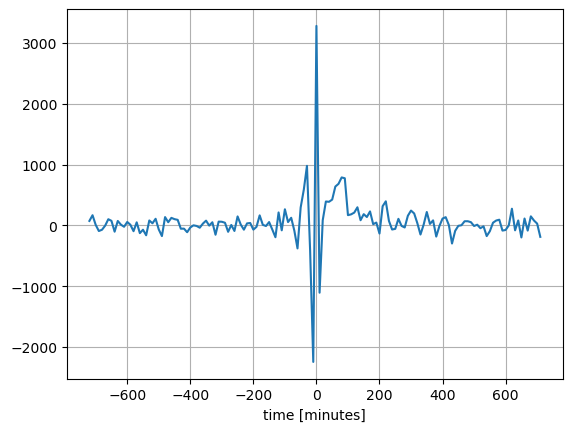

In [11]:
%%time

ds = D[2].resample(time="10min").mean()
das = ds["strain_rate"].isel(distance=10)

dt = float((ds.time.diff("time")/pd.Timedelta("1days")).median("time"))
irf_length = int(0.5/dt) # 0.5 day

irf_inferred, ds["das_inferred"], reg = irf_inference(
    ds["temperature_dt"], das, irf_length, symmetrical=True,
)
print(reg)

fig, ax = plt.subplots(1,1)
irf_inferred.plot()
ax.grid()

The IRF above is still noisy, tweaking optimization parameter might improve the result, to be tried.

#### on 30min averaged data:

Optimization terminated successfully.
         Current function value: 0.033626
         Iterations: 7
         Function evaluations: 5125
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.0336262783612205
       x: [ 1.174e+02  2.714e+01 ... -4.258e+01 -5.158e+01]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 5125
CPU times: user 259 ms, sys: 4.51 ms, total: 263 ms
Wall time: 263 ms


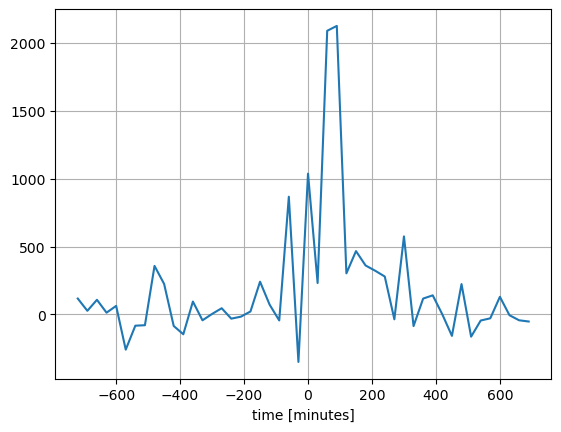

In [12]:
%%time

ds = D[2].resample(time="30min").mean()
das = ds["strain_rate"].isel(distance=10)

dt = float((ds.time.diff("time")/pd.Timedelta("1days")).median("time"))
irf_length = int(0.5/dt) # 0.5 day

irf_inferred, ds["das_inferred"], reg = irf_inference(
    ds["temperature_dt"], das, irf_length, symmetrical=True,
)
print(reg)

fig, ax = plt.subplots(1,1)
irf_inferred.plot()
ax.grid()

#### on 60 min averaged data:

Optimization terminated successfully.
         Current function value: 0.029384
         Iterations: 7
         Function evaluations: 2785
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.029384444470317454
       x: [-9.466e+01  3.113e+02 ...  1.328e+02  9.406e+01]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 2785
CPU times: user 109 ms, sys: 4.43 ms, total: 113 ms
Wall time: 115 ms


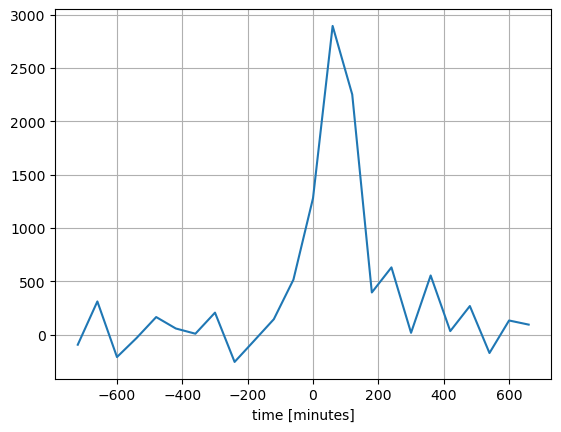

In [13]:
%%time

ds = D[2].resample(time="60min").mean()
das = ds["strain_rate"].isel(distance=10)

dt = float((ds.time.diff("time")/pd.Timedelta("1days")).median("time"))
irf_length = int(0.5/dt) # 0.5 day

irf_inferred, ds["das_inferred"], reg = irf_inference(
    ds["temperature_dt"], das, irf_length, symmetrical=True,
)
print(reg)

fig, ax = plt.subplots(1,1)
irf_inferred.plot()
ax.grid()

In [9]:
def irf_inference_param(
    temperature, das, irf_length, 
    symmetrical=False,
    #lambda_l2=.1, lambda_smooth=.1,
    #lambda_l2=0, lambda_smooth=0,
    demean=True,
    opt_kwargs={},
):
    """ perform an inference of the impulse response function in the time domain
    
    Assumptions:
        - temperature and das data are a common time line
        - temperature data may NOT contain NaNs
        - das data may contain NaNs (corresponding to gaps)

    Parameters
    ----------
    temperature, das: xr.DataArray's
        input time series
    irf_length: int
        length of the impulse response function to be estimated
    symmetrical: boolean
        enables a symmetrical time lags for the definition of the impulse response function
    lambda_l2: float
        parameter constraining the amplitude of impulse response function values
    lambda_smooth: float
        parameter constraining the smoothness of impulse response function
    demean: boolean
        automatically demean time series
    opt_kwargs: dict
        options for the optimization method
    """

    if demean:
        temperature = temperature - temperature.mean("time")
        das = das - das.mean("time")
    dt = pd.to_timedelta(temperature["time"].diff("time").median().values)
    minute = pd.Timedelta("1min")/dt
    hour = pd.Timedelta("1hour")/dt
    
    x = temperature.data
    y = das.data

    # mask start/end points which are not valid because of the convolution
    y[:irf_length] = np.nan
    y[-irf_length:] = np.nan
    
    assert x.ndim==1 and y.ndim==1, "temperature and das data should be one dimensional"
    
    assert np.isnan(x).sum()==0, "temperature contains bad values"
    y = np.nan_to_num(das.values, nan=0.0)          # Output series (convolved)
    valid = ~np.isnan(y)        # Only use points where output is not NaN
    
    def cost_function_reg(p):
        """ cost function to be minimized """
        
        if symmetrical:
            t_kernel = np.arange(-irf_length, irf_length)/minute
            h = p[0]/t_kernel**(3/2) * np.exp(-p[1]/t_kernel)
            h[irf_length] = 0
            y_pred = np.convolve(x, h, mode='full')[len(h)//2:][:len(x)]
            lag = np.arange(-irf_length, irf_length)
        else:
            t_kernel = np.arange(irf_length)
            h = p[0]/t_kernel**(3/2) * np.exp(p[1]/t_kernel)
            h[0] = 0
            y_pred = np.convolve(x, h, mode='full')[:len(x)]
            lag = np.arange(irf_length)
        #mse = np.mean((y[valid] - y_pred[valid])**2)
        mse = np.mean(np.abs(y[valid] - y_pred[valid]))
        l2_penalty = lambda_l2 * np.mean(h**2 / np.exp(-np.abs(lag)/hour))
        smooth_penalty = lambda_smooth * np.mean(np.diff(h)**2)
        return mse + l2_penalty + smooth_penalty

    # Initial guess (as before): dirac
    p0 = [1, hour]
    
    # Optimize with regularization
    #_kwargs = dict(method='L-BFGS-B') # https://github.com/scipy/scipy/issues/23161
    _kwargs = dict(
        #method='L-BFGS-B', options=dict(gtol=1e-10),
        #method='nelder-mead', options=dict(maxiter=int(1e6), disp=True, xatol=1e-10, fatol=1e-10)
        method='powell', options=dict(maxiter=int(1e4), disp=True, xtol=1e-10, ftol=1e-10),
    )
    
    _kwargs.update(opt_kwargs)
    result_reg = minimize(cost_function_reg, p0, **_kwargs)
    p_inferred = result_reg.x

    if symmetrical:
        t_kernel = np.arange(-irf_length, irf_length)/minute
        h = p[0]/t_kernel**(3/2) * np.exp(-p[1]/t_kernel)
        h[irf_length] = 0
        y_pred = np.convolve(x, h, mode='full')[len(h)//2:][:len(x)]
        lag = np.arange(-irf_length, irf_length)
    else:
        t_kernel = np.arange(irf_length)
        h = p[0]/t_kernel**(3/2) * np.exp(p[1]/t_kernel)
        h[0] = 0
        y_pred = np.convolve(x, h, mode='full')[:len(x)]
        lag = np.arange(irf_length)
    
    irf_inferred = 

    # gather in one dataset
    irf = xr.DataArray(irf_inferred, dims="time", coords={"time": t_kernel*(dt/pd.Timedelta("1min"))})
    irf["time"].attrs.update(units="minutes")

    # predict das from temperature and the inferred response function
    das_inferred = generate_das_data(temperature, irf, symmetrical=symmetrical)

    #return irf, result_reg
    return irf, das_inferred, result_reg

SyntaxError: invalid syntax (4144979739.py, line 103)